In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from scipy.optimize import curve_fit
import astropy.units as u
import astropy.constants as c
import glob
import matplotlib as mpl

In [2]:
plt.rc('axes', labelsize=14)
plt.rc('figure', titlesize=30)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('xtick.major', size=6)    # size of the tick markers
plt.rc('ytick.major', size=6)    # size of the tick markers
plt.rc('xtick.minor', size=4)    # size of the tick markers
plt.rc('ytick.minor', size=4)    # size of the tick markers
# BP Plot stylization parameters.

colors = mpl.colormaps['Dark2'].colors

In [3]:
# dir = r'/home/baparker/GitHub/Research/CCDs/Sophia/Data/20241102/PTC'
# save_dir = r'/home/baparker/GitHub/Research/CCDs/Sophia/Photos'

dir = r'C:\Users\Brock\Documents\Git\Research\CCDs\Sophia\Data\20241102\PTC'
save_dir = r'C:\Users\Brock\Documents\Git\Research\CCDs\Sophia\Photos'

science_in_list_1 = glob.glob(dir + r'\science_*_1.fits')
science_in_list_2 = glob.glob(dir + r'\science_*_2.fits')
dark_in_list_1 = glob.glob(dir + r'\dark_*_1.fits')
dark_in_list_2 = glob.glob(dir + r'\dark_*_2.fits')
bias_in_list_1 = glob.glob(dir + r'\bias_*_1.fits')
bias_in_list_2 = glob.glob(dir + r'\bias_*_2.fits')

science_in_list_1.sort()
science_in_list_2.sort()
dark_in_list_1.sort()
dark_in_list_2.sort()
bias_in_list_1.sort()
bias_in_list_2.sort()

In [24]:
# regions = np.arange(0, 1900, 10)
rng = np.random.default_rng()

idx = 20
num = 200
size = 2048

regions = np.rint(rng.random(num)*(size - idx)).astype(int)

signal_array = []
error_array = []
rn_array = []
affy_signal_array = []
affy_error_array = []

for science1, science2, bias1, bias2 in zip(science_in_list_1, science_in_list_2, bias_in_list_1, bias_in_list_2):
    s1 = fits.getdata(science1)
    b1 = fits.getdata(bias1)[0]
    rn1 = np.std(b1)# - np.mean(b1))
    
    s2 = fits.getdata(science2)
    b2 = fits.getdata(bias2)[0]
    rn2 = np.std(b2)# - np.mean(b2))

    rn_array.append(rn1)
    rn_array.append(rn2)

    for region in regions:
        imagef1_sec=s1[region:region+idx, region:region+idx]
        imageb1_sec=b1[region:region+idx, region:region+idx]
        imagef2_sec=s2[region:region+idx, region:region+idx]
        imageb2_sec=b2[region:region+idx, region:region+idx]

        mb1=np.mean(imageb1_sec)
        mb2=np.mean(imageb2_sec)

        Np = imagef1_sec.size

        var = (np.sum(((imagef2_sec-mb2)-(imagef1_sec-mb1))**2))/(2*Np)
        mf = np.mean((imagef2_sec-mb2+imagef1_sec-mb1)/2) 

        s1_reg = s1[region:region+idx, region:region+idx]
        s2_reg = s2[region:region+idx, region:region+idx]
        b1_reg = b1[region:region+idx, region:region+idx]
        b2_reg = b2[region:region+idx, region:region+idx]

        offset_signal1 = s1_reg - np.mean(b1_reg)
        offset_signal2 = s2_reg - np.mean(b2_reg)

        diff = offset_signal1 - offset_signal2
        avg_im = (offset_signal1 + offset_signal2) / 2

        signal = np.mean(avg_im)

        error = np.std(diff) / np.sqrt(2)

        if error==0:
            pass
        else:
            signal_array.append(signal)
            error_array.append(error)

        if error==0:
            pass
        else:
            affy_signal_array.append(mf)
            affy_error_array.append(np.sqrt(var))

signal_array = np.array(signal_array)
error_array = np.array(error_array)
affy_signal_array = np.array(affy_signal_array)
affy_error_array = np.array(affy_error_array)

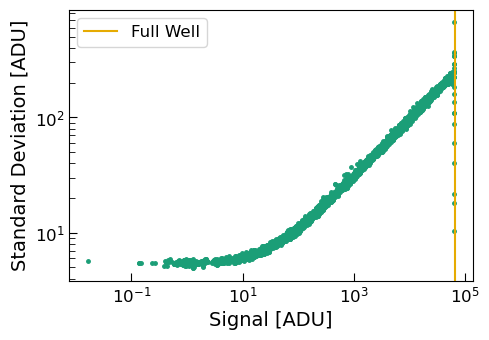

In [25]:
fig, ax = plt.subplots(layout='tight', figsize=(5,3.5))

# ax.plot(affy_signal_array, affy_error_array, ls='', marker='.', color=colors[3], markersize=5, label='Affy')
ax.plot(signal_array, error_array, ls='', marker='.', color=colors[0], markersize=5)#, label='Brock')

ax.set_xlabel(r'Signal [ADU]')
ax.set_ylabel(r'Standard Deviation [ADU]')
ax.tick_params(axis='both', direction='in', which='both')
plt.axvline(65536, color=colors[5], label='Full Well')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left')
fig.tight_layout()
#plt.savefig(save_dir + r'\Sophia_PTC_Bias_20241102.png'.format(step),dpi = 500)
plt.show()

Fit the logarithm of the data, both x and y, to a line. The y data has the read noise subtracted, although this should have very little affect on the calculated gain.

In [6]:
def line(x, b):
    return 0.5 * x + b

def fit_log_line(xdata, ydata, rn):
    log_x_data = np.log10(xdata)
    log_y_data = np.log10(ydata - rn)

    popt, pcov = curve_fit(line, log_x_data, log_y_data)
    #popt, pcov = curve_fit(lambda x, b: line(x, 0.5, b), log_x_data, log_y_data)
    perr = np.sqrt(np.diag(pcov))

    return popt, perr

4.97
1.1894976958345234 electron / DN


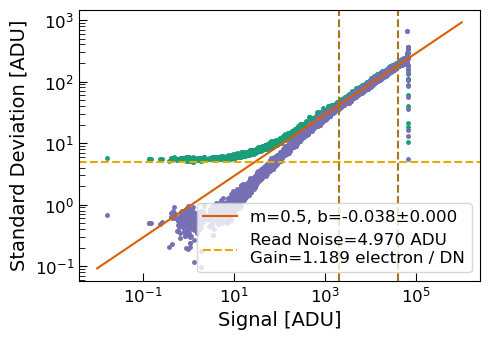

In [32]:
#rn = np.mean(rn_array)
#print(rn)
rn = 4.97
#print(rn)
#rn = np.min(error_array)
#print(rn)
# Get readnoise as std of the bias
#rn = 0
print(rn)

lower = 2e3
upper = 4e4

cut_idx = (signal_array>lower) & (signal_array<upper)

popt, perr = fit_log_line(signal_array[cut_idx], error_array[cut_idx], rn)

calc_gain = 10**(-popt[0]/0.5) * u.electron / u.DN

print(calc_gain)

fig, ax = plt.subplots(layout='tight', figsize=(5,3.5))

x = np.linspace(-2, 6, 1000)

ax.plot(signal_array, error_array, ls='', marker='.', color=colors[0], markersize=5)
ax.plot(signal_array, error_array-rn, ls='', marker='.', color=colors[2], markersize=5)
# ax.plot(10**x, 10**line(x, 0.5, *popt), ls='-', color=colors[1], label='m=0.5, b={:.3f}±{:.3f}'.format(popt[0], perr[0]))
ax.plot(10**x, 10**line(x, *popt), ls='-', color=colors[1], label='m=0.5, b={:.3f}±{:.3f}'.format(popt[0], perr[0]))

ax.set_xlabel(r'Signal [ADU]')
ax.set_ylabel(r'Standard Deviation [ADU]')
ax.tick_params(axis='both', direction='in', which='both')
plt.axhline(rn, ls='--', color=colors[5], label='Read Noise={:.3f} ADU\nGain={:.3f}'.format(rn, calc_gain))
plt.axvline(lower, ls='--', color=colors[6])
plt.axvline(upper, ls='--', color=colors[6])
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
fig.tight_layout()
#plt.savefig(save_dir + r'\Sophia_PTC_Bias_20241102.png'.format(step),dpi = 500)
plt.show()

In [33]:
10**popt

array([0.91689203])

In [42]:
rn = np.mean(rn_array)
print(rn)
rn = 4.97

lower = 2e3
upper = 4e4

cut_idx = (signal_array>lower) & (signal_array<upper)

popt, perr = fit_rn_line(signal_array[cut_idx], error_array[cut_idx])


5.602762179172362


In [47]:
popt

array([-0.02857573,  0.2624964 ])

1.1406475387029673 electron / DN


C:\Users\Brock\AppData\Local\Temp\ipykernel_100\1116414738.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.e**b * x**(0.5) + rn


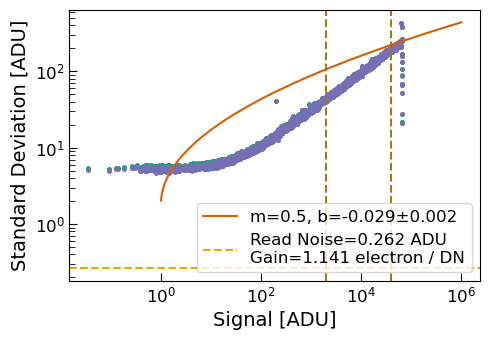

In [48]:
rn = popt[1]
calc_gain = 10**(-popt[0]/0.5) * u.electron / u.DN

print(calc_gain)

fig, ax = plt.subplots(layout='tight', figsize=(5,3.5))

x = np.linspace(-2, 6, 1000)

ax.plot(signal_array, error_array, ls='', marker='.', color=colors[0], markersize=5)
ax.plot(signal_array, error_array-rn, ls='', marker='.', color=colors[2], markersize=5)
ax.plot(10**x, 10**model(x, *popt), ls='-', color=colors[1], label='m=0.5, b={:.3f}±{:.3f}'.format(popt[0], perr[0]))
# ax.plot(10**x, 10**line(x, *popt), ls='-', color=colors[1], label='m=0.5, b={:.3f}±{:.3f}'.format(popt[0], perr[0]))

ax.set_xlabel(r'Signal [ADU]')
ax.set_ylabel(r'Standard Deviation [ADU]')
ax.tick_params(axis='both', direction='in', which='both')
plt.axhline(rn, ls='--', color=colors[5], label='Read Noise={:.3f} ADU\nGain={:.3f}'.format(rn, calc_gain))
plt.axvline(lower, ls='--', color=colors[6])
plt.axvline(upper, ls='--', color=colors[6])
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower right')
fig.tight_layout()
#plt.savefig(save_dir + r'\Sophia_PTC_Bias_20241102.png'.format(step),dpi = 500)
plt.show()

In [14]:
popt

array([ 1.        , -0.04659503])

In [ ]:
#!/usr/bin/python
import pandas as pd
import os.path
import glob
import matplotlib.pyplot as plt
import sys
from glob import glob
import numpy as np
import glob
import os
from pathlib import Path
import matplotlib.colors as mcolors
from astropy.io import fits
from scipy.optimize import curve_fit
from astropy.nddata import Cutout2D
from astropy.visualization import (MinMaxInterval, SqrtStretch,ImageNormalize)
import random
import traceback

# plt.style.use(r'D:\Nuvu_data\science.mplstyle')

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e'])
plt.rcParams['figure.figsize'] = (3, 2.625)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['legend.frameon'] = False
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.05
plt.rcParams['font.serif'] = ['cmr10', 'Computer Modern Serif', 'DejaVu Serif']
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size']='18'


dir_path=r'/media/nuvu_setup/Data_Volume/wl18d10_data/ptc_new_adc_04252024/vss5/ptc_06'
detector_name='w18d10'

def linefit(x, A, B):
    
    """
    Generate a line.

    Parameters
    ----------
    x : numpy array
        Linear vector

    a : float
        Line slope

    b : float
        Line intercept

    Returns
    -------
    Line function.
    """

    return A*x + B

def fitLine(x, y, param = None):
    """
    Fit a line.

    Parameters
    ----------
    x : numpy array
        One dimensional vector.

    y : numpy array
        One dimensional vector.

    param : list
       List of guess parameters
    """
    popt, pcov = curve_fit(linefit, x, y, p0 = param)

    a, b = popt

    return (a, b)

def get_data(wl,exptime,coat,Region,center_position,size,Signal,Var,image_fname,bias_fname):
    import datetime
    data = {
        'wl': [],
        'exptime':[],
        'coat':[],
        'Region': [],
        'center_position': [],
        'size': [],
        'Signal':[],
        'Var':[],
        'image_fname':[],
        'bias_fname':[]
        }
    data['wl'].append(wl)
    data['exptime'].append(exptime)
    data['coat'].append(coat)
    data['Region'].append(Region)
    data['center_position'].append(center_position)
    data['size'].append(size)
    data['Signal'].append(Signal)
    data['Var'].append(Var)
    data['image_fname'].append(image_fname)
    data['bias_fname'].append(bias_fname)
    return data

def generate_ptc_db(dir_path):
    dir_path_list=sorted(glob.glob(dir_path))
    filename='ptc_log.csv'

    print(f"Going through dir: {dir_path}")
    log_file=r'ptc_log.csv'
    log_path=os.path.join(dir_path,log_file)
    images_db=pd.read_csv(log_path,index_col=0)
    file_list=sorted(glob.glob(os.path.join(dir_path,'*.fits.Z')))
    if len(file_list)!=np.shape(images_db)[0]: 
        print(f"The number of files in folder is {len(file_list)} While the number of files in database are {np.shape(images_db)[0]}.")
        start_index= len(file_list)-np.shape(images_db)[0]
        file_list=file_list[start_index:]
        images_db['filenames']=file_list
    else: 
        images_db['filenames']=file_list

    db_path=str(Path(dir_path).parents[0])
    flat_db=images_db[images_db['imtype']=='Flat'].reset_index()
    bias_db=images_db[images_db['imtype']=='Bias'].reset_index()
    dark_db=images_db[images_db['imtype']=='Dark'].reset_index()    
    images_db.to_csv(os.path.join(dir_path,'images_db.csv'))
    flat_db.to_csv(os.path.join(dir_path,'flat_db.csv'))
    bias_db.to_csv(os.path.join(dir_path,'bias_db.csv'))
    dark_db.to_csv(os.path.join(dir_path,'dark_db.csv'))
    return images_db,flat_db,bias_db,dark_db


def generate_regions_data(dir_path,images_db,flat_db,bias_db):
    wl='dalpha'
    explist=images_db['Exp_time'].unique()
    gainlist = []
    readnoiselist = []
    signallist = []

    coat_width=300
    coat_sep=30
    centx=3216/2
    centy=2069/2
    segments=13
    nregions=1
    colors=random.choices(list(mcolors.CSS4_COLORS.keys()),k=segments*nregions)
    analysis_width=600
    analysis_height=150
    print(f"list of unique exposures: {explist}")
    print(f"Number of Analysis regions [nregionsxsegments]: {segments*nregions}")
    print(f"Analysis region width: {analysis_width}")
    print(f"Analysis region heigh: {analysis_height}")

    coat1_regcentx=centx+coat_width/2+coat_sep/2
    coat1_regcenty=centy

    coat2_regcentx=centx-coat_width/2-coat_sep/2
    coat2_regcenty=centy
    biasfile=0
    centerx_list=[(coat1_regcentx+coat2_regcentx)/2]
    centery_list=np.linspace(centy-((segments-1)/2)*analysis_height,centy+((segments-1)/2)*analysis_height,segments)

    mrx,mry=np.meshgrid(centerx_list,centery_list)
    center_reg_glist=tuple(zip(np.ravel(mrx), np.ravel(mry)))
    poslist=()

    for idx,regcenters in enumerate(center_reg_glist): 
        centerx=regcenters[0]
        centery=regcenters[1]
        nregions=nregions
        offsetx=analysis_width
        offsety=analysis_height

        coat=idx
        centrangex=np.linspace(centerx,centerx,nregions)
        centrangey=np.linspace(centery,centery,nregions)
        mgx,mgy=np.meshgrid(centrangex,centrangey)
        poslist=poslist+tuple(zip(np.ravel(mgx), np.ravel(mgy)))
        # # pos_list3
        
    fig,ax=plt.subplots(figsize=(30,10))
    ex_implot=explist[14]
    b_filename=bias_db[bias_db['Exp_time']==ex_implot].filenames.values[0]
    imageb0 = np.array(fits.getdata(b_filename))

    ##modified from j to i index for one data set
    imageb0=imageb0*1.0
    f_filename=flat_db[flat_db['Exp_time']==ex_implot].filenames.values[0]

    imagef0 = np.array(fits.getdata(f_filename)) ##modified from j to i index for one data set
    imagef0 = imagef0*1.0

    interval = MinMaxInterval()
    vmin, vmax = interval.get_limits(imagef0-imageb0)
    # Create an ImageNormalize object using a SqrtStretch object
    # norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())
    norm=ImageNormalize(vmin=20, vmax=vmax, stretch=SqrtStretch())
    im=ax.imshow(imagef0-imageb0,cmap='Greys_r',norm=norm,origin='lower')
    fig.colorbar(im)

    for idx,pos in enumerate(poslist): 
        position = pos
        size = (analysis_height, analysis_width)     # pixels
        cutoutf0=Cutout2D(imagef0, position, size,)
        cutoutf0.plot_on_original(color=colors[idx],label=idx+1)

    for idxb, exp_time in enumerate(explist): 
        print(exp_time)
        if idxb>len(explist)-2:
            break                    
        b1_filename=bias_db[bias_db['Exp_time']==exp_time].filenames.values[biasfile]
        imageb1 = np.array(fits.getdata(b1_filename)) 
        b2_filename=bias_db[bias_db['Exp_time']==exp_time].filenames.values[biasfile+1]
        imageb2 = np.array(fits.getdata(b2_filename))
        imageb1 = imageb1*1.0
        imageb2 = imageb2*1.0
        f1_filename=flat_db[flat_db['Exp_time']==exp_time].filenames.values[0]
        imagef1 = np.array(fits.getdata(f1_filename)) ##modified from j to i index for one data set
        f2_filename=flat_db[flat_db['Exp_time']==exp_time].filenames.values[1]
        imagef2 = np.array(fits.getdata(f2_filename))
        imagef1 = imagef1*1.0
        imagef2 = imagef2*1.0
        imagef12 = np.subtract(imagef1,imagef2)
        imageb12 = np.subtract(imageb1,imageb2)
        
    
        reg=1
        for centers in poslist:
            regsize = (analysis_height,analysis_width) 
            center_pos= centers
            # print(center_pos)
            imagef1_sec=Cutout2D(imagef1, center_pos, regsize).data
            imageb1_sec=Cutout2D(imageb1, center_pos, regsize).data
            imagef2_sec=Cutout2D(imagef2, center_pos, regsize).data
            imageb2_sec=Cutout2D(imageb2, center_pos, regsize).data
            #imaged_sec=Cutout2D(imaged, center_pos, regsize).data
            mf1=np.mean(imagef1_sec)
            mf2=np.mean(imagef2_sec)
            mb1=np.mean(imageb1_sec)
            mb2=np.mean(imageb2_sec)
            
            sigmaf1=np.std(imagef1_sec)
            sigmaf2=np.std(imagef2_sec)
            sigmab1=np.std(imageb1_sec)
            sigmab2=np.std(imageb2_sec)

            Np = imagef1_sec.size
            #taking out FPN by substracting two images with same exposure duration
            var= (np.sum(((imagef2_sec-mb2)-(imagef1_sec-mb1))**2))/(2*Np)
            #Average Signal from the two images 
            mf = np.mean((imagef2_sec-mb2+imagef1_sec-mb1)/2) 
            if idxb==0:
                region_data =pd.DataFrame(get_data(wl=wl,exptime=exp_time,coat="",Region=reg,center_position=center_pos,size=regsize,Signal=mf, Var=var,image_fname=f_filename,bias_fname=b_filename))
            else:
                temp_data =pd.DataFrame(get_data(wl=wl,exptime=exp_time,coat="",Region=reg,center_position=center_pos,size=regsize,Signal=mf, Var=var,image_fname=f_filename,bias_fname=b_filename))
                region_data=pd.concat([region_data,temp_data],ignore_index=True)
            reg=reg+1
    ax.legend(loc='lower right')
    ax.set_xlim(1072*1.5-1024/2,1.5*1072+1024/2)
    plt.grid(alpha=0.2)
    plt.title(f"Sample image for ptc curve, Exptime={ex_implot}")
    ax.set_xlabel("x pixels")
    ax.set_xlabel("y pixels")
    regions_filename=os.path.join(dir_path,f'regions_{str(os.path.basename(dir_path))}.png')
    plt.savefig(regions_filename)
    print(f"regions plot saved at {regions_filename}")
    print(f"Signma bias frames= {sigmab1}")
    region_data.to_csv(os.path.join(dir_path,f'regions_{str(os.path.basename(dir_path))}.csv'))
    return region_data,sigmab1

    # print(region_data.Signal)
    # print(region_data.Var)

def ptc_plot(dir_path,region_data,sigb1):
        flag =1#used to manual overide the read noise calculation 
        min_sig=2000#min sig for shot noise fit #1000 #20
        max_sig=10000 #max sig for shot noise fit #5000 #5000
        plt_xmin=1
        plt_xmax=66000
        plt_ymin=1
        plt_ymax=250
        region_data['rms_noise'] = np.sqrt(np.array(region_data.Var))
        region_data['log_rms_noise']=np.log10(region_data.rms_noise)
        region_data['log_signal'] = np.log10(region_data.Signal)
        #RN=sigb1
        #readnoise=RN
        rn_calc = region_data[np.logical_and(region_data.rms_noise>0,region_data.rms_noise<=sigb1)].rms_noise
        # print(rn_calc)
        readnoise = np.mean(rn_calc)
        print(readnoise)
        if np.isnan(readnoise):
            rn_factor=0.985
            print("Read noise estimate from low exposure images resulted in nans. Using read noise factor instead.")
            print(f"rn_factor={rn_factor}")
            RN=rn_factor*sigb1
            readnoise=rn_factor*sigb1
        else: 
            if flag !=1: #flag for manaul override. 
                rn_factor=1.0
                RN=readnoise
                print("Read noise estimate from low exposure images: {RN}. Using read noise factor =1.")
            else: 
                rn_factor=1.0
                print("Read noise noise estimate override. Using read noise factor instead.")
                print(f"rn_factor={rn_factor}")
                RN=rn_factor*sigb1
                readnoise=rn_factor*sigb1
          
        region_data['log_shot_noise']=np.real(np.log10(np.sqrt((region_data.rms_noise)**2 - (RN)**2)))        
        shot_noise_data=region_data[np.logical_and(region_data.Signal>int(min_sig),region_data.Signal<int(max_sig))]    
        maxsig = np.nanmax(shot_noise_data.Signal)
        xfit = np.arange(np.log10(0.05),maxsig+(0.5*maxsig),0.005)
        s_fixed=0.5000       
        b = shot_noise_data.log_shot_noise-s_fixed*shot_noise_data.log_signal
        print('Shot noise fit parameters with fixed slope and variable intercept')
        print(f'Slope (fixed)={np.round(s_fixed,4)}')
        print(f'Intercept (variable)= {np.round(np.mean(b),4)}')
        
        log_signal_fit = shot_noise_data.log_signal
        log_shot_noise_fit = shot_noise_data.log_shot_noise
        print(f"{log_shot_noise_fit =}")
        slope, intercept = fitLine(log_signal_fit,log_shot_noise_fit)
        print("Shot noise fit parameters with slope and intercept as variables")
        print(f'Slope (fixed)={np.round(slope,4)}')
        print(f'Intercept (variable) = {np.round(intercept,4)}')
        preamp_gain = (1.0/10**(np.nanmean(b)))**2

        readnoise = preamp_gain*RN
        print(f'Bias noise from Bias frame= {np.round(sigb1,3)}  ADU')
        print(f'Readnoise from Bias frame = {np.round(preamp_gain*sigb1,3)} e-')
        print(f'Conversion Gain = {np.round(preamp_gain,3)} e-/ADU')
        print(f'Readnoise from fit = {np.round(readnoise,3)} e-')
        
        fig,ax=plt.subplots(figsize=(10,10))
        #Signal vs Shot noise for fit b
        #Signl vs Shot noise for all data
        ax.scatter(region_data.Signal,np.sqrt(region_data.Var),color='cyan',s=5,alpha=0.5,label='Total Noise')
        ax.scatter(10**region_data.log_signal,10**region_data.log_shot_noise,color='grey',s=15,alpha=0.25,label='Shot noise')
        ax.scatter(10**log_signal_fit,10**log_shot_noise_fit,color='crimson',s=15,label='Shot noise for gain fit')
        #Fitline for Shot nois
        ax.plot(10**np.arange(-2,np.max(log_signal_fit),0.01),10**linefit(np.arange(-2,np.max(log_signal_fit),0.01),0.5,np.mean(b)),color='black',linestyle='--',label=f'Shot noise fit line, b={np.round(np.mean(b),2)},s={np.round(0.5,2)}')
        ax.vlines(np.max(region_data.Signal),1,region_data.rms_noise[region_data.Signal==np.max(region_data.Signal)],color='tomato',label='Full well capacity (ADU)',linestyle='dotted',linewidth=1)
        ax.hlines(sigb1,1,np.max(region_data.Signal),color='green',label=f'Read noise',linestyle='dashdot',linewidth=1)
        # ax.hlines(sigb1,1,np.max(region_data.Signal),color='green',label=f'Read noise (ADU)={rn_factor}x Biasnoise',linestyle='dashdot',linewidth=1)
        # ax.scatter(10**np.arange(-2,np.max(log_signal_fit),0.01),RN*np.ones(len(np.arange(-2,np.max(log_signal_fit),0.01))),color='grey',s=15,alpha=0.25,label='Read noise (ADU)'
        # ax.plot(10**region_data.log_signal,sigb1*np.ones(len(10**region_data.log_signal)))
        ax.set_xlabel("Signal (ADU)")
        ax.set_ylabel("Noise (ADU)")
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(which='both', color='Grey',alpha=0.3,linestyle='--')
        # plt.title(f"Photon Transfer Curve for {detector_name}, Read noise={rn_factor}x{np.round(sigb1,2)} \n Dataset: {str(os.path.basename(dir_path))}")
        plt.title(f"Photon Transfer Curve for {detector_name} at 183 K\n Dataset: {str(os.path.basename(dir_path))}")
        plt.legend()
        
        ax.set_xlim(plt_xmin,plt_xmax)
        ax.set_ylim(plt_ymin,plt_ymax)
        textstr = f'Bias frame noise= {np.round(sigb1,3)} ADU\n'+f'Readnoise from bias frame= {np.round(preamp_gain*sigb1,3)} e-\n'+f'Conversion gain = {np.round(preamp_gain,3)} e-/ADU \n'+f'Readnoise from PTC fit = {np.round(readnoise,3)} e-'
        
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        # place a text box in upper left in axes coords
        ax.text(0.55, 0.25, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        
        fig_file=os.path.join(dir_path,f'ptcplot_{str(os.path.basename(dir_path))}.png')
        print(f"PTC plot saved at {fig_file}")
        plt.savefig(os.path.join(dir_path,f'ptcplot_{str(os.path.basename(dir_path))}.png'))
            # Save signal and noise data to a CSV file
        csv_file = os.path.join(dir_path, f'ptc_data_{str(os.path.basename(dir_path))}.csv')
        
        # Additional information for the header
        header_info = {
            'Detector Name': detector_name,
            'Dataset': str(os.path.basename(dir_path)),
            'Conversion Gain': np.round(preamp_gain, 3),
            'Readnoise from PTC fit': np.round(readnoise, 3),
            'Bias Noise from Bias frame': np.round(sigb1, 3),
            'Shot Noise Fit Slope': np.round(slope, 4),
            'Shot Noise Fit Intercept': np.round(intercept, 4)
        }

        # Create a DataFrame with signal and noise data
        ptc_data = pd.DataFrame({
            'Signal': region_data.Signal,
            'Total Noise': np.sqrt(region_data.Var),
            'Log Signal': region_data.log_signal,
            'Log Shot Noise': region_data.log_shot_noise
        })

        # Save the DataFrame to CSV with additional header information
        ptc_data.to_csv(csv_file, index=False, header=True)

        # Append additional information to the header
        with open(csv_file, 'a') as file:
            file.write('\n')
            for key, value in header_info.items():
                file.write(f'# {key}: {value}\n')

        print(f"Signal and noise data saved at {csv_file}")

def main(): 
    images_db,flat_db,bias_db,dark_db=generate_ptc_db(dir_path)
    region_data,sigmab1 = generate_regions_data(dir_path,images_db,flat_db,bias_db)
    ptc_plot(dir_path,region_data,sigmab1)

if __name__=="__main__":
    
    analysis_log_path='ptc_analysis_log.txt'
    if os.path.isfile(analysis_log_path): 
        print("Analysis log exists. Overwriting the default log file.")
    else: 
        print("Analysis log does not exists. Creating a new analysis log file. Console output will be printed in log instead.")
        fp = open(analysis_log_path, 'x')
        fp.close()
    try: 
        sys.stdout = open(os.path.join(dir_path,'ptc_analysis_log.txt'), 'w')
        main()
        sys.stdout.close()
    except Exception as error: 
        print(f"Something went wrong check analysis log: {error}")
        traceback.print_exc()